# DATA MINING PROJECT: Analysis of a Supermarket’s Customers
## 3.2) Predictive Analysis: Label computation
### *Antonio Strippoli, Valerio Mariani*

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, davies_bouldin_score

pd.set_option('mode.chained_assignment', None)

In [2]:
def plot(ax, folder="clustering_kmeans", filename="", figsize=(6.4, 4.8)):
    fig = plt.gcf()
    fig.set_size_inches(*figsize)
    plt.tight_layout()
    if filename:
        path = os.path.join("..", "report", "imgs", folder)
        if not os.path.exists(path):
            os.mkdir(path)
        plt.savefig(os.path.join(path, filename))
    plt.show()
    plt.close()

In [3]:
# Load dataset
cl = pd.read_csv("classification.csv", index_col=0)
cl = cl[cl['NTransactions'] >= 41]

               Monetary  NTransactions  TotItems     cat_0     cat_1     cat_2
Monetary       1.000000       0.440514  0.922778  0.434389  0.399689  0.340479
NTransactions  0.440514       1.000000  0.446279  0.997667  0.822894  0.539658
TotItems       0.922778       0.446279  1.000000  0.447581  0.341479  0.324414
cat_0          0.434389       0.997667  0.447581  1.000000  0.782339  0.514371
cat_1          0.399689       0.822894  0.341479  0.782339  1.000000  0.604564
cat_2          0.340479       0.539658  0.324414  0.514371  0.604564  1.000000


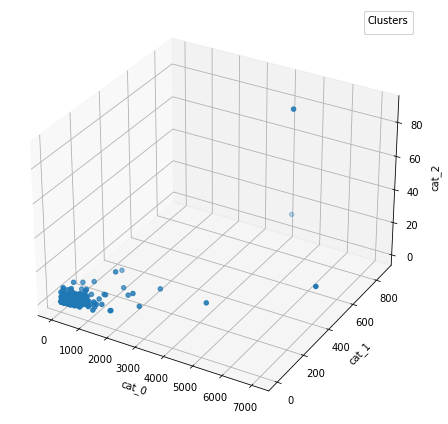

In [4]:
print(cl.corr())

# 3D Scatter plot of the attributes clusterized
def cluster_scatter_3d(cdf_cluster, attr_cluster, colors=None, cm=None, view_init=None, filename=""):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    c1, c2, c3 = attr_cluster
    scatter = ax.scatter3D(cdf_cluster[c1], cdf_cluster[c2], cdf_cluster[c3], c=colors, label=colors, s=20, cmap=cm)
    ax.set_xlabel(c1)
    ax.set_ylabel(c2)
    ax.set_zlabel(c3)

    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    if view_init:
        ax.view_init(*view_init)

    plot(None, figsize=(6,6), filename=filename)

cluster_scatter_3d(cl, ['cat_0', 'cat_1', 'cat_2'])

Computation of the labels through clustering

In [ ]:
# attr_cluster = cl.columns
attr_cluster = ['cat_0', 'cat_1', 'cat_2']
cl_cluster = cl[attr_cluster]

# Normalize values
scaler = MinMaxScaler() # Minmax?
X = scaler.fit_transform(cl_cluster.values)

In [ ]:
# Estimize best values for eps
dist = pdist(X, 'euclidean')
dist = squareform(dist)

k = 4
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plot(None, filename="Eps_Estimation")

In [ ]:
# We choosed 0.046 as our eps and 4 as our min_samples, proceede with the clusterization
dbscan = DBSCAN(eps=0.03, min_samples=100)
dbscan.fit(X)

sil = round(silhouette_score(X, dbscan.labels_), 2)
db = round(davies_bouldin_score(X, dbscan.labels_), 2)
print("Silhouette:", sil)
print("Davies Bouldin:", db)

# Save number of clusters
k = len(np.unique(dbscan.labels_))

# Define a new colormap to employ in the visualizations
colors = np.array([
    (219, 42, 42, 255), # Red
    (42, 48, 219, 255), # Blue
    (80, 219, 42, 255), # Green
    (42, 219, 213, 255), # Cyan
    (219, 116, 42, 255), # Orange
    (219, 42, 213, 255) # Fuchsia
])
colors = colors[:k]
colors = colors / 255.0
cm = LinearSegmentedColormap.from_list('clusters_6', colors, N=6)

In [ ]:
# 3D Scatter plot of the attributes clusterized
cluster_scatter_3d(cl, ['cat_0', 'cat_1', 'cat_2'], colors=dbscan.labels_, cm=cm)

In [ ]:
plot(cl.plot.scatter(x='Monetary', y='TotItems', c=dbscan.labels_, cmap=cm))
_, counts = np.unique(dbscan.labels_, return_counts=True)
counts

In [ ]:
cl['labels'] = dbscan.labels_
cl = cl[cl['labels'] == 0]
cl.drop('labels', axis=1)

In [ ]:
attr_cluster = ['cat_0', 'cat_1', 'cat_2']
# attr_cluster = cl.columns
cl_cluster = cl[attr_cluster]

# Normalize values
scaler = MinMaxScaler() # Minmax?
X = scaler.fit_transform(cl_cluster.values)

In [ ]:
# We choosed 3 as our number of clusters, proceede with the clusterization
kmeans = KMeans(n_clusters=3, init="k-means++", n_init=100, max_iter=1000)
kmeans.fit(X)

sse = round(kmeans.inertia_, 2)
sil = round(silhouette_score(X, kmeans.labels_), 2)
db = round(davies_bouldin_score(X, kmeans.labels_), 2)
print("SSE:", sse)
print("Silhouette:", sil)
print("Davies Bouldin:", db)

# Save centroids
centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Define a new colormap to employ in the visualizations
colors = np.array([
    (219, 42, 42, 255), # Red
    (219, 116, 42, 255), # Orange
    (80, 219, 42, 255), # Green
    (42, 219, 213, 255), # Cyan
    (42, 48, 219, 255), # Blue
])
colors = colors / 255.0
cm = LinearSegmentedColormap.from_list('clusters_6', colors, N=5)

In [ ]:
cluster_scatter_3d(cl, ['cat_0', 'cat_1', 'cat_2'], colors=kmeans.labels_, cm=cm)

In [ ]:
cl[(cl['TotItems'] < 1000) & (cl['Monetary'] < 1000)].plot.scatter(x='Monetary', y='TotItems')

In [ ]:
cl.plot.scatter(x='Monetary', y='TotItems', c=kmeans.labels_, cmap=cm)

In [ ]:
cl['lables'] = kmeans.labels_